In [1]:
!pip install openpyxl
!pip install folium
import pandas as pd
import numpy as np
import os
from project_tools.utils import load_data

# Data Analyzing: Standard Deviation of Traffic

This part of the analysis focuses specfically on the standard deviation of the Traffic Data. The Standard Deviation is a statistical measure that quantifies the amount of dispersion or spread of a dataset around its mean. By analyzing the Standard Deviation of the Bart traffic data, we can gain insights into the degree of fluctuation in the number of commuters across different time interval.

## i. Standard Deviation of Exit Station: Weekday vs Weekends

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

weekdays = ['Weekday', 'Saturday', 'Sunday']
years = range(2015, 2019)

def stdByWeekday(weekday):
    df = pd.DataFrame()
    for year in years:
        single_df = load_data(year)
        df = pd.concat([df, single_df], ignore_index=False)
    df = df[df['Sheet Name'].str.contains(weekday)]
    filtered_columns = [col for col in df.columns if len(col) == 2]
    # Filter out the Unnessary Columns
    df = df[filtered_columns + ['Exit Station']]
    df = df[df['Exit Station'] != 'Entries']
    
    grouped_data = df.groupby('Exit Station')
    std_matrix = grouped_data.std()
    std_matrix = std_matrix.sort_index(axis=0)  # Sort rows
    std_matrix = std_matrix.sort_index(axis=1)  # Sort columns

    return std_matrix

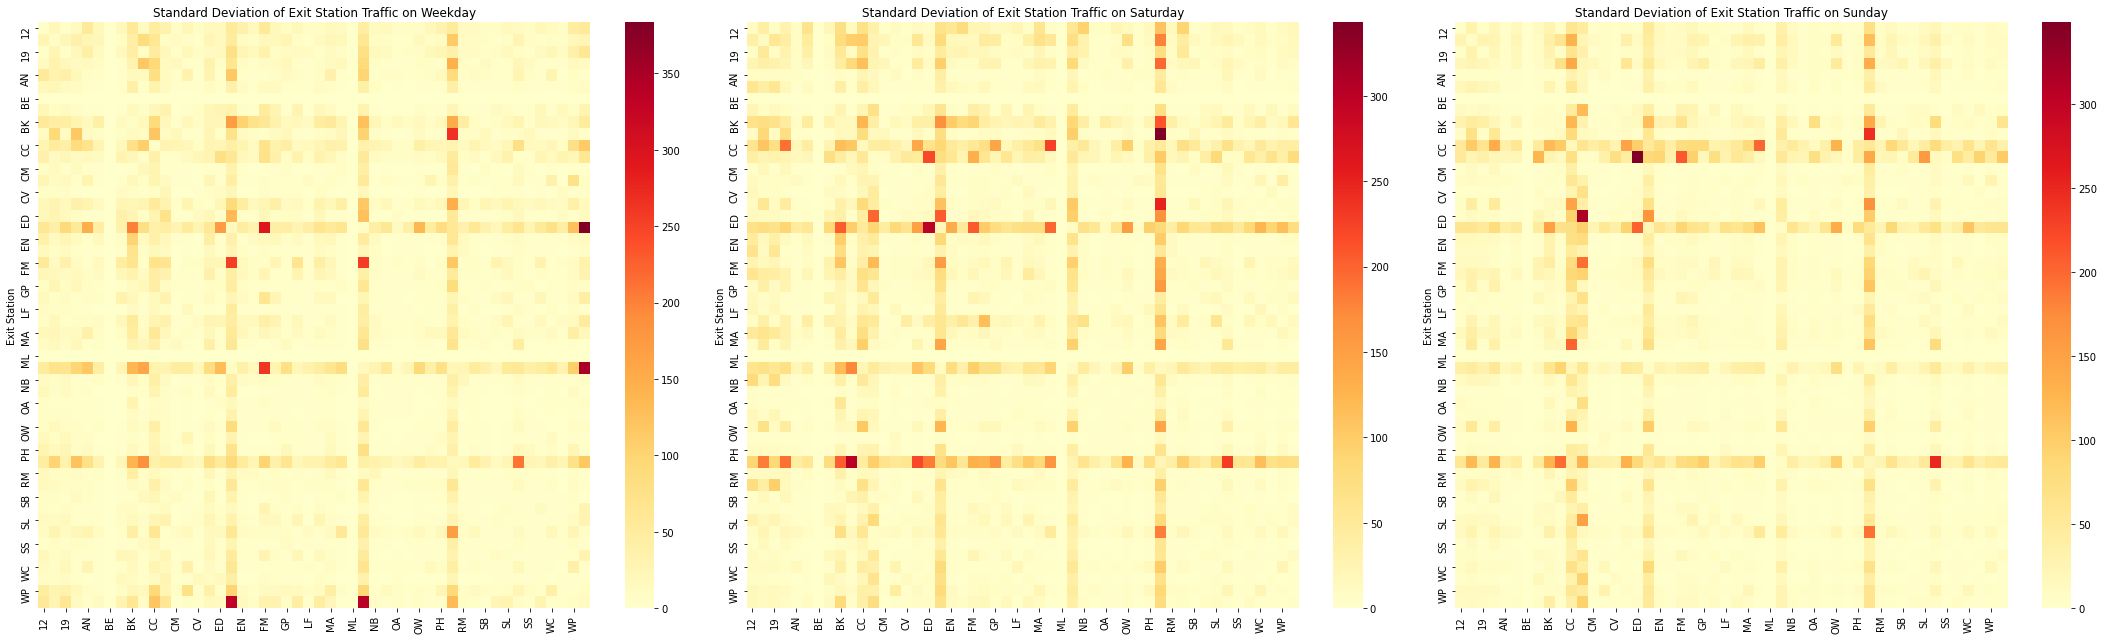

In [3]:
dfs = [stdByWeekday(weekday) for weekday in weekdays]
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 9))

# Iterate over each subplot and DataFrame to create the heat plots
for ax, df, weekday in zip(axes.flatten(), dfs, weekdays):
    sns.heatmap(df, cmap='YlOrRd', ax=ax)
    ax.set_title(f"Standard Deviation of Exit Station Traffic on {weekday}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


We can see here that Weekdays traffic has the least amount of dispersion while Saturday data has the most amount of dispersion. Moreover, the darker red dots distributes in mostly same places in the Saturday graph and the Sunday graph. 

Stations such as Civic Center(`CC`) and Embarcadero(`EM`) has a significant increase on fluctuation from Weekday plot to Weekends plot(see the darker shade of the verticle lines), which infers that these station are located at commerical areas with an inconsistent and flexable traffic flows. We will further investigate this idea and later use this piece of information later where we designate stations to different types of land use.

To further illustrate our points, we calculate the standard deviation of total average daily traffic on weekdays and on weekends, from 2016 to 2018. 

In [4]:
dfs = [load_data(year) for year in years]
df = pd.concat(dfs)
for weekday in weekdays:
    df = df[df['Exit Station'] == 'Entries']
    weekday_df = df[df['Sheet Name'].str.contains(weekday)]
    std_dev = np.std(weekday_df['Exits'])
    print(f"{weekday} : {std_dev}")

Weekday : 13383.409247592897
Saturday : 18888.234318365146
Sunday : 16897.5775013141


As expected, we draw the same conclusion as the station-wise graph, which is that Saturday's traffic flow is the most fluctant, and Weekday's traffic is the least. The difference in the standard deviation of traffic between weekdays and weekends can be attributed to several factors related to human behavior and routines.

1. Consistent Work/School Schedule: Weekdays typically follow a structured work or school schedule for a significant portion of the population. Commuters tend to have regular routines and predictable travel patterns, resulting in more consistent traffic patterns. This regularity leads to less variability in the number of commuters and subsequently a smaller standard deviation.

2. Reduced Commuter Variety: On weekends, the composition of commuters may vary significantly compared to weekdays. Weekends often see a mix of different activities such as leisure, recreation, and personal errands. This variety in commuter types and purposes can lead to a wider range of traffic patterns, resulting in a larger standard deviation.

3. Time Flexibility: On weekends, people often have more flexibility in choosing their travel times. This flexibility can lead to a more dispersed distribution of commuter traffic throughout the day, resulting in a higher standard deviation compared to weekdays when rush hours and specific work/school schedules dominate the traffic patterns.

4. Reduced Rush Hour Effects: Weekdays usually have distinct rush hours when a significant number of commuters travel to and from work or school simultaneously. These peak hours can create a more concentrated and predictable traffic flow, leading to a smaller standard deviation. On weekends, the absence or less pronounced rush hour effects can contribute to a higher standard deviation.

Overall, the combination of regular work/school schedules, reduced commuter variety, predictable rush hours, and the more structured nature of weekdays contributes to a smaller standard deviation in traffic. Conversely, the increased flexibility, variety of activities, and reduced rush hour effects on weekends tend to result in a larger standard deviation in traffic patterns.


## ii. Which Stations have the most fluctant traffic, and why?

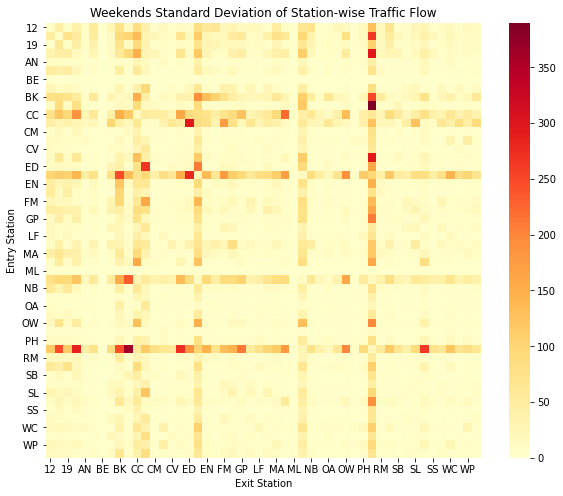

In [5]:
dfs = [load_data(year) for year in years]
df = pd.concat(dfs)

df = df[(df['Sheet Name'].str.contains('Saturday') | df['Sheet Name'].str.contains('Sunday'))]
df = df[df['Exit Station'] != 'Entries']
grouped_data = df.groupby('Exit Station')

std_matrix = grouped_data.std()
std_matrix = std_matrix.sort_index(axis=0)  # Sort rows
std_matrix = std_matrix.sort_index(axis=1)  # Sort columns
filtered_columns = [col for col in std_matrix.columns if len(col) == 2] # Filter out the Unnessary Columns
std_matrix = std_matrix[filtered_columns]

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(std_matrix, cmap='YlOrRd', square=True, cbar=True)

# Set the plot title and axis labels
plt.title('Weekends Standard Deviation of Station-wise Traffic Flow')
plt.xlabel('Exit Station')
plt.ylabel('Entry Station')

# Show the heatmap
plt.show()

We sum up the traffic data from year 2015 to 2018, and based on the previous analysis, filter out only the weekend data. After calculating the standard devation based on stations, we found out the stations with the most the most fluctant traffic are all located at Downtown San Francisco with one exception(`CC`). Namely, these four stations:
- Civic Center (`CC`)
- Embarcadero (`EM`)
- Montgomery Street (`MT`)
- Powell Street(`PL`)

As we can see, all of these locations are located at the San Francisco CBD, which begs the question: Is there a correlation between the type of land use of a station and its level of fluctuation of traffic?

We choose four different categories of land use with the following stations:
- Commercial Usage, with the most representative region being the San Francisco CBD. This category contains four station:
    - Civic Center(`CC`)
    - Embarcadero(`EM`)
    - Montgomery Street(`MT`)
    - Powell Street(`PL`)
- Academic Usage, with the most representative region being those surronding Berkeley campus. This category contains two station:
    - Downtown Berkeley(`BK`)
- Mixed Usage, with Oakland as a representation since it has a nice mixture of residential and commercial areas. This category contains:
    - Ashby(`AS`)
    - MacArthur(`MA`)
    - 19th Street Oakland(`19`)
    - 12th Street / Oakland City Center(`12`)
    - West Oakland(`OW`)
- Transport Usage, with two station of international airport:
    - Oakland International Airport(`OA`)
    - San Francisco International Airport(`SO`)

In [6]:
def stdOnEntries(weekend=True):
    dfs = [load_data(year) for year in years]
    df = pd.concat(dfs)
    if (weekend): 
        df = df[(df['Sheet Name'].str.contains('Saturday') | df['Sheet Name'].str.contains('Sunday'))]
    else: 
        df = df[(df['Sheet Name'].str.contains('Weekday'))]
    df = df[df['Exit Station'] == 'Entries']
    filtered_columns = [col for col in df.columns if len(col) == 2] # Filter out the Unnessary Columns
    df = df[filtered_columns]
    std_df = df.std().sort_index(ascending=False)
    std_df.dropna(inplace=True)
    std_df = std_df[std_df > 0] # remove zero since some station is closed during weekends and the std is 0
    return std_df

In [7]:
std_weekends = stdOnEntries(True)
std_weekdays = stdOnEntries(False)
commerce = ['CC', 'EM', 'MT', 'PL']
school = ['BK']
mix = ['AS', 'MA', '19', '12', 'OW']
transport = ['OA', 'SO']
def printRankingSTD(land_type, series):
    for station in land_type:
        ranking = series.rank(ascending=False)
        output = "|   {:2s}    |   {:2d}    |    {:<13f}   |".format(station, int(ranking[station]), series[station])
        print(output)
        
print("Here is the ranking of standard deviation on weekends based on land types:")
print("We have a total of " + str(len(std_weekends)) + " stations")
print("| Station | Ranking | Standard Deviation |")
print("=" * 15 + " Commerce " + "=" * 16)
printRankingSTD(commerce, std_weekends)
print("=" * 16 + " School " + "=" * 17)
printRankingSTD(school, std_weekends)
print("=" * 18 + " Mix " + "=" * 18)
printRankingSTD(mix, std_weekends)
print("=" * 15 + " Transport " + "=" * 15)
printRankingSTD(transport, std_weekends)
print('='*41)

Here is the ranking of standard deviation on weekends based on land types:
We have a total of 48 stations
| Station | Ranking | Standard Deviation |
=============== Commerce ================
|   CC    |    3    |    2424.176346     |
|   EM    |    2    |    2830.647603     |
|   MT    |    4    |    2122.867073     |
|   PL    |    1    |    4387.185515     |
================ School =================
|   BK    |    5    |    1978.032026     |
================== Mix ==================
|   AS    |   23    |    563.657715      |
|   MA    |   17    |    769.760560      |
|   19    |   10    |    1036.354981     |
|   12    |   11    |    1035.911162     |
|   OW    |   13    |    841.088848      |
=============== Transport ===============
|   OA    |   41    |    280.599278      |
|   SO    |   21    |    634.119151      |


Here we can see that station for Commerce land and used for commute to school  have the highest standard deviation while station for Transport purposes have much lower standard deviation.

For further investigation, we aim to determine why a BART exit station has a higher standard deviation in passenger traffic. We suspect that the concentration of passengers from a single station versus a more even distribution could be a correlated factor. In the following section, we plot the standard deviation, both for weekend and weekday traffics, and also the ratio of the entry station with the highest number traffic, to the total traffic coming through all entry stations. 

In [8]:
dfs = [load_data(year) for year in years]
df = pd.concat(dfs) 
grouped_df = df.groupby("Exit Station").sum()
largest_values = grouped_df.apply(lambda x: x.nlargest(2).iloc[0])
second_largest_values = grouped_df.apply(lambda x: x.nlargest(2).iloc[1])
ratio = (second_largest_values / largest_values).sort_index(ascending=False)
ratio = ratio[ratio.index.str.len() == 2]
ratio.dropna(inplace=True)

Now with the ratio in `Pandas` series, we plot the three series in the same graph, with different scales since the standard deviation is way larger.

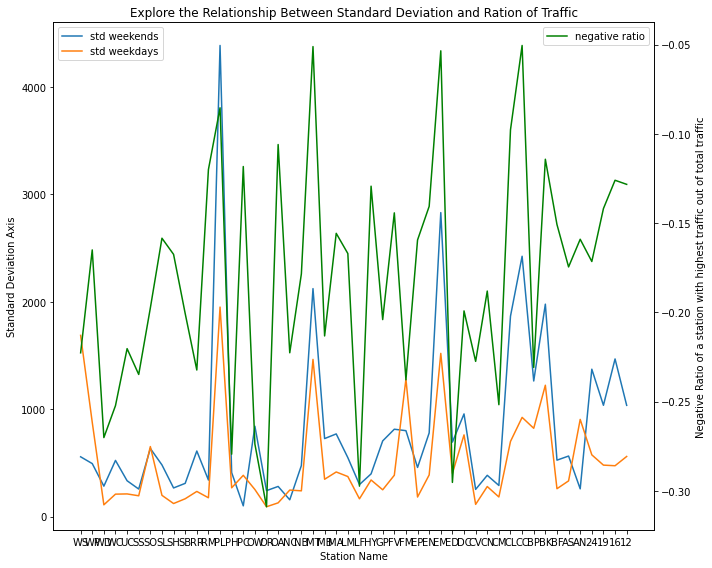

In [9]:
negative_ratio = - ratio 
fig, ax1 = plt.subplots(figsize=(10, 8))
# Plot standard deviation of weekends and weekday traffic
ax1.plot(std_weekends.index, std_weekends.values, label='std weekends')
ax1.plot(std_weekdays.index, std_weekdays.values, label='std weekdays')

# Plot the ratio
ax2 = ax1.twinx()
ax2.plot(negative_ratio.index, negative_ratio.values, label='negative ratio', color='green')
ax2.set_ylabel('Negative Ratio of a station with highest traffic out of total traffic')
# Set labels and title
ax1.set_xlabel('Station Name')
ax1.set_ylabel('Standard Deviation Axis')
ax1.set_title('Explore the Relationship Between Standard Deviation and Ration of Traffic')

# Add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()

# Display the graph
plt.show()

In [10]:
correlation_weekdays = std_weekdays.corr(ratio)
correlation_weekends = std_weekends.corr(ratio)
print(correlation_weekdays)
print(correlation_weekends)

-0.4493593308217461
-0.5754065661308386


The correlation coefficient measures the strength and direction of the linear relationship between the variables, ranging from -1 to 1. Here we can see there is a moderatly negative correlation between the ratio of traffic from the busiest entry station and the standard deviation of traffic from every entry station.